# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

#import lightgbm as lgb
#import xgboost as xgb
import catboost as ctb
#from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")


# Preprocessing

In [5]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])


In [6]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df
    

# CatB

In [7]:
ctb_params = {
   'loss_function': 'RMSE',
     'eval_metric': 'RMSE',
    'n_estimators':N_ESTIMATORS,
    
    'bootstrap_type': 'MVS',
    'max_depth': 7,
    'learning_rate': 0.008631898678482117, 
    'max_bin': 513, 
    'min_data_in_leaf': 106, 
    'reg_lambda': 0.33198521893488897, 
    'subsample': 0.6710454521793958
}


In [8]:
ctb_oof = np.zeros(train.shape[0])
ctb_pred = np.zeros(test.shape[0])
ctb_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[scale_features], y=train[target])):
    print(f"===== fold {fold} =====")
    
    if fold >= 5:
    
        X_train, y_train = train[scale_features].iloc[trn_idx], train[target].iloc[trn_idx]
        #X_train = apply_noise_row(X_train)

        X_valid, y_valid = train[scale_features].iloc[val_idx], train[target].iloc[val_idx]
        X_test = test[scale_features]



        # CatB       
        start = time.time()

        for inseed in seed_list:
            ctb_params['random_seed'] = inseed

            pre_model = ctb.CatBoostRegressor(**ctb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                use_best_model=True,
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE
            )


            ctb_params2 = ctb_params.copy()
            ctb_params2['reg_lambda'] *= 0.9
            #ctb_params2['alpha'] *= 0.9
            ctb_params2['learning_rate'] *= 0.1
            model = ctb.CatBoostRegressor(**ctb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    use_best_model=True,
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    init_model=pre_model
            )    

            with open(f"ctb_model{fold}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            ctb_importances = ctb_importances.append(fi_tmp)

            ctb_oof[val_idx] += model.predict(X_valid) / len(seed_list)
            ctb_pred += model.predict(X_test) / len(seed_list)

        elapsed = time.time() - start
        rmse = mean_squared_error(y_valid, ctb_oof[val_idx], squared=False)
        print(f"fold {fold} - ctb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

    
        
print(f"oof ctb_rmse = {mean_squared_error(train[target], ctb_oof, squared=False)}")

np.save("ctb_oof.npy", ctb_oof)
np.save("ctb_pred.npy", ctb_pred)


===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
===== fold 5 =====
0:	learn: 7.9396185	test: 7.9413989	best: 7.9413989 (0)	total: 173ms	remaining: 28m 49s
1000:	learn: 7.8286969	test: 7.8820539	best: 7.8820539 (1000)	total: 1m 44s	remaining: 15m 35s
2000:	learn: 7.7566474	test: 7.8654329	best: 7.8654208 (1999)	total: 3m 22s	remaining: 13m 27s
3000:	learn: 7.6852823	test: 7.8561728	best: 7.8561728 (3000)	total: 5m	remaining: 11m 41s
4000:	learn: 7.6173975	test: 7.8511988	best: 7.8511988 (4000)	total: 6m 39s	remaining: 9m 59s
5000:	learn: 7.5530922	test: 7.8477687	best: 7.8476910 (4968)	total: 8m 20s	remaining: 8m 20s
6000:	learn: 7.4896269	test: 7.8448599	best: 7.8448443 (5990)	total: 9m 59s	remaining: 6m 39s
7000:	learn: 7.4281321	test: 7.8429397	best: 7.8429259 (6952)	total: 11m 37s	remaining: 4m 58s
8000:	learn: 7.3681952	test: 7.8412534	best: 7.8412074 (7986)	total: 13m 15s	remaining: 3m 18s
Stopped by overfitting detector  (200 iterati

# OOF predictions

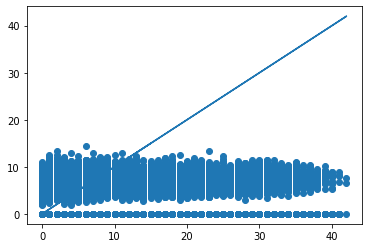

In [9]:
plt.plot(train[target], train[target])
plt.scatter(train[target], ctb_oof)

# Features importances

Text(0.5, 1.0, 'CatB feature importances')

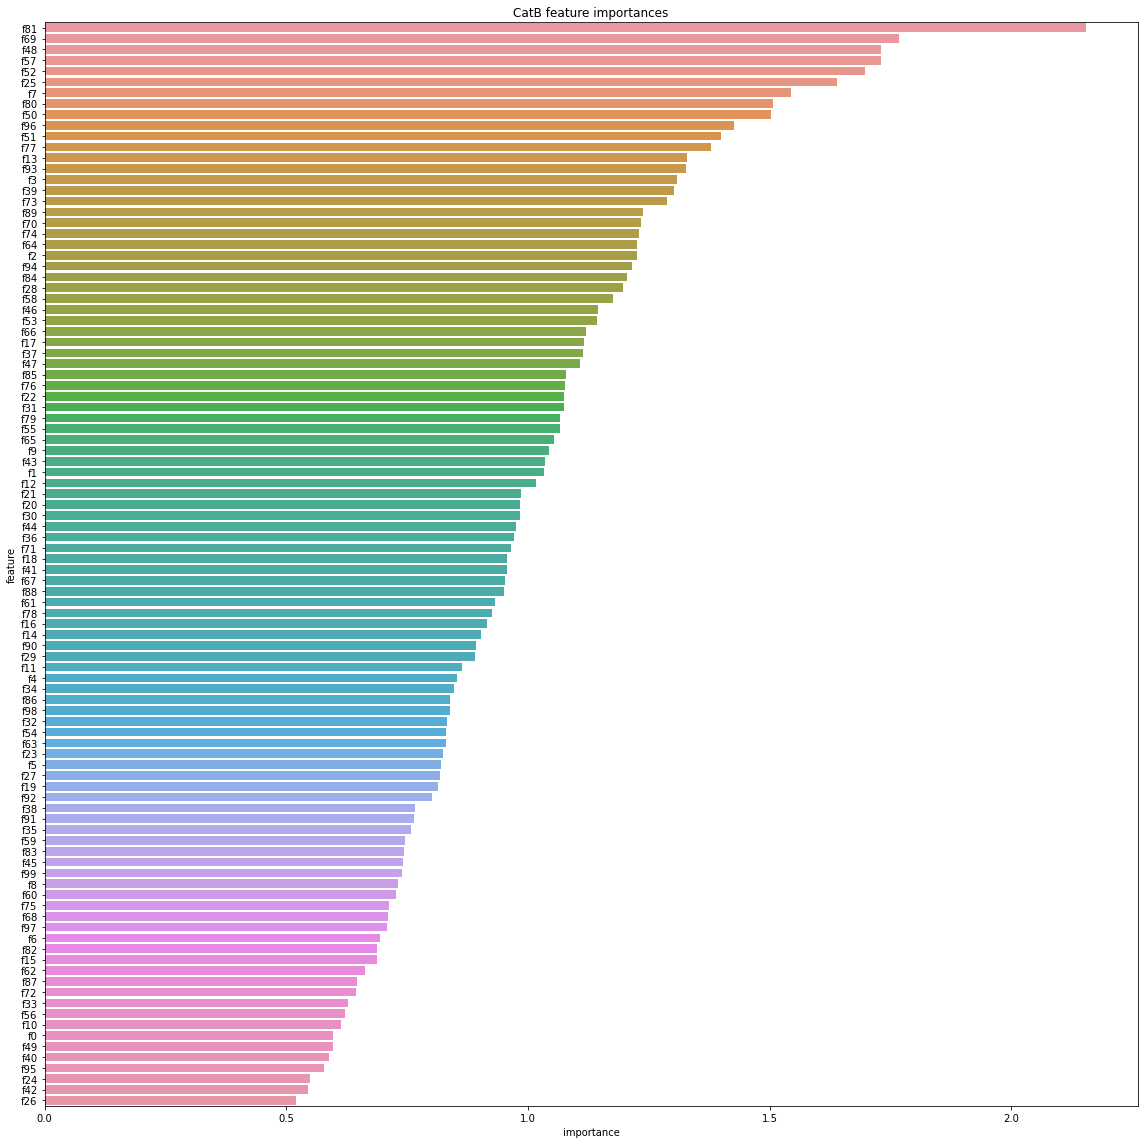

In [10]:
order = list(ctb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=ctb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("CatB feature importances")

# Submission

In [11]:
submission[target] = ctb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,40.341199
1,250001,22.757718
2,250002,41.712458
3,250003,36.854043
4,250004,36.522924
...,...,...
149995,399995,37.712400
149996,399996,35.718261
149997,399997,30.155139
149998,399998,25.900741


# Log

ver2 fold 0-4

ver3 fold 5-9